In [1]:
#############################################################################################
# Copyright (C)																				#
# 2019 Aditya Rastogi(r.aditya0824@gmail.com)												#
# Permission given to modify the code as long as you keep this declaration at the top 		#
#############################################################################################

In [2]:
#IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
import sys

In [3]:
#Problem Parameters
class jcp:
    @staticmethod
    def max_cars():
        return 20
    
    @staticmethod
    def gamma():
        return 0.9
    
    @staticmethod
    def credit_reward():
        return 10
    
    @staticmethod
    def moving_reward():
        return -2
    
    @staticmethod
    def second_parking_lot_reward():
        return -4

In [4]:
class poisson_:
    
    def __init__(self, Lambda):
        self.Lambda = Lambda
        
        epsilon = 0.01
        
        
        # [alpha , beta] is the range of n's for which the pmf value is above epsilon
        self.alpha = 0
        state = 1
        self.vals = {}
        summer = 0
        
        while(1):
            if state == 1:
                temp = poisson.pmf(self.alpha, self.Lambda) 
                if(temp <= epsilon):
                    self.alpha+=1
                else:
                    self.vals[self.alpha] = temp
                    summer += temp
                    self.beta = self.alpha+1
                    state = 2
            elif state == 2:
                temp = poisson.pmf(self.beta, self.Lambda)
                if(temp > epsilon):
                    self.vals[self.beta] = temp
                    summer += temp
                    self.beta+=1
                else:
                    break    
        
        # normalizing the pmf, values of n outside of [alpha, beta] have pmf = 0
        
        added_val = (1-summer)/(self.beta-self.alpha)
        for key in self.vals:
            self.vals[key] += added_val
        
            
    def f(self, n):
        try:
            Ret_value = self.vals[n]
        except(KeyError):
            Ret_value = 0
        finally:
            return Ret_value

In [5]:
#A class holding the properties of a location together
class location:
    
    def __init__(self, req, ret):
        self.alpha = req                             #value of lambda for requests
        self.beta = ret                             #value of lambda for returns
        self.poissonalpha = poisson_(self.alpha)
        self.poissonbeta = poisson_(self.beta)

In [6]:
#Location initialisation

A = location(3,3)
B = location(4,2)

In [7]:
#Initializing the value and policy matrices. Initial policy has zero value for all states.

value = np.zeros((jcp.max_cars()+1, jcp.max_cars()+1))
policy = value.copy().astype(int)

In [8]:
def apply_action(state, action):
    return [max(min(state[0] - action, jcp.max_cars()),0) , max(min(state[1] + action, jcp.max_cars()),0)]

In [9]:
def expected_reward(state, action):
    global value
    """
    state  : It's a pair of integers, # of cars at A and at B
    action : # of cars transferred from A to B,  -5 <= action <= 5 
    """
    
    
    psi = 0 #reward
    new_state = apply_action(state, action)    
    
    # adding reward for moving cars from one location to another (which is negative) 
    
    if action <= 0:
        psi = psi + jcp.moving_reward() * abs(action)
    else:
        psi = psi + jcp.moving_reward() * (action - 1)    #one car is moved by one of Jack's employees for free
    
    # adding reward for second parking lot (which is also negative)
    
    if new_state[0] > 10:
        psi = psi + jcp.second_parking_lot_reward()
        
    if new_state[1] > 10:
        psi = psi + jcp.second_parking_lot_reward()
    
    # there are four discrete random variables which determine the probability distribution of the reward and next state
    
    for Aalpha in range(A.poissonalpha.alpha, A.poissonalpha.beta):
        for Balpha in range(B.poissonalpha.alpha, B.poissonalpha.beta):
            for Abeta in range(A.poissonbeta.alpha, A.poissonbeta.beta):
                for Bbeta in range(B.poissonbeta.alpha, B.poissonbeta.beta):
                    """
                    Aalpha : sample of cars requested at location A
                    Abeta : sample of cars returned at location A
                    Balpha : sample of cars requested at location B
                    Bbeta : sample of cars returned at location B
                    zeta  : probability of this event happening
                    """
                    
                    # all four variables are independent of each other
                    zeta = A.poissonalpha.vals[Aalpha] * B.poissonalpha.vals[Balpha] * A.poissonbeta.vals[Abeta] * B.poissonbeta.vals[Bbeta]
                    
                    valid_requests_A = min(new_state[0], Aalpha)
                    valid_requests_B = min(new_state[1], Balpha)
                    
                    rew = (valid_requests_A + valid_requests_B)*(jcp.credit_reward())
                    
                    #calculating the new state based on the values of the four random variables
                    new_s = [0,0]
                    new_s[0] = max(min(new_state[0] - valid_requests_A + Abeta, jcp.max_cars()),0)
                    new_s[1] = max(min(new_state[1] - valid_requests_B + Bbeta, jcp.max_cars()),0)
                    
                    #Bellman's equation
                    psi += zeta * (rew + jcp.gamma() * value[new_s[0]][new_s[1]])
                    
    return psi

In [10]:
def policy_evaluation():
    
    global value
    
    # here policy_evaluation has a static variable epsilon whose values decreases over time
    epsilon = policy_evaluation.epsilon
    
    policy_evaluation.epsilon /= 10 
    
    while(1):
        delta = 0
        
        for i in range(value.shape[0]):
            for j in range(value.shape[1]):
                # value[i][j] denotes the value of the state [i,j]
                
                old_val = value[i][j]
                value[i][j] = expected_reward([i,j], policy[i][j])
                
                delta = max(delta, abs(value[i][j] - old_val))
                # print('.', end = '')
                # sys.stdout.flush()
        print(delta)
        sys.stdout.flush()
    
        if delta < epsilon:
            break

In [11]:
#initial value of epsilon
policy_evaluation.epsilon = 50

In [12]:
def policy_improvement():
    
    global policy
    
    policy_stable = True
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            old_action = policy[i][j]
            
            max_act_val = None
            max_act = None
            
            τ12 = min(i,5)       # if I have say 3 cars at the first location, then I can atmost move 3 from 1 to 2
            τ21 = -min(j,5)      # if I have say 2 cars at the second location, then I can atmost move 2 from 2 to 1
            
            for act in range(τ21,τ12+1):
                sigma = expected_reward([i,j], act)
                if max_act_val == None:
                    max_act_val = sigma
                    max_act = act
                elif max_act_val < sigma:
                    max_act_val = sigma
                    max_act = act
                
            policy[i][j] = max_act
            
            if old_action!= policy[i][j]:
                policy_stable = False
    
    return policy_stable

In [13]:
def save_policy():
    save_policy.counter += 1
    ax = sns.heatmap(policy, linewidth=0.5, cmap='YlGnBu')
    ax.invert_yaxis()
    plt.show()
    # plt.savefig('policy'+str(save_policy.counter)+'.svg')
    plt.close()
    
def save_value():
    save_value.counter += 1
    ax = sns.heatmap(value, linewidth=0.5, cmap='YlGnBu')
    ax.invert_yaxis()
    plt.show()
    # plt.savefig('value'+ str(save_value.counter)+'.svg')
    plt.close()

In [14]:
save_policy.counter = 0
save_value.counter = 0

169.90008661446765
119.08501115392248
81.88529858652572
64.74616803795342
51.78927693943169
40.39506710856131


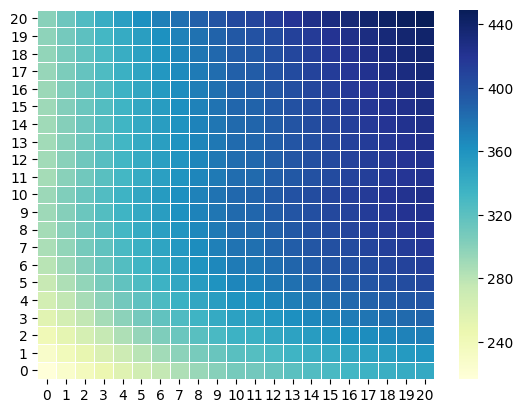

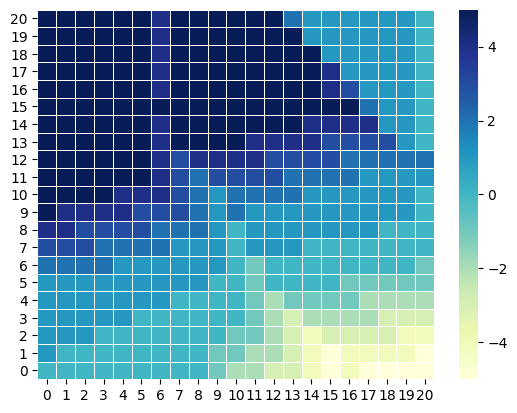

130.22573474640814
33.99200127408341
25.5137555739268
21.803711257236273
18.193578565608277
15.003757302147903
12.324400552542386
10.109486138542536
8.287630717823049
6.791937570775872
5.565161733198636
4.559477221055772


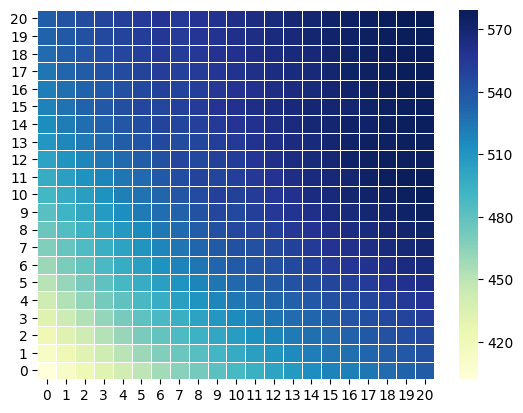

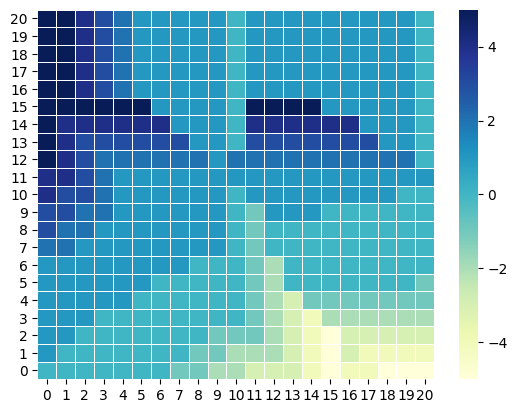

12.962009107281688
6.645207466001352
3.646856734470475
2.4594042279098858
1.9803626503397709
1.5567917632563422
1.276453605979441
1.0510267391509274
0.8633221543227592
0.7081625047539433
0.5804264746623744
0.47550893404741146


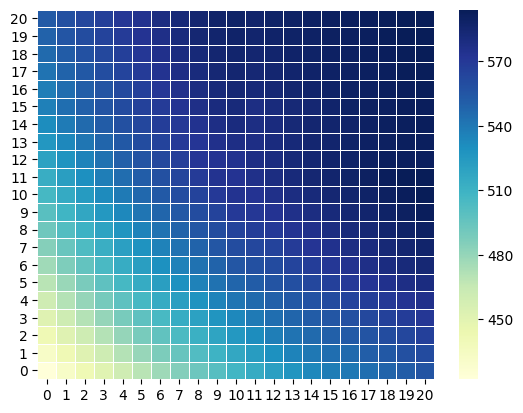

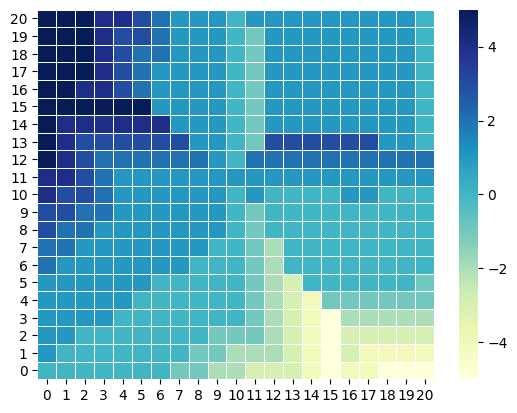

3.2601566893927156
0.4516798693352939
0.26849425327606014
0.2197258616595832
0.17977468957758447
0.14718244083888976
0.12053995030186115
0.09872777649013642
0.08085784823032327
0.06621535006286194
0.05421864291071188
0.04439153050952882


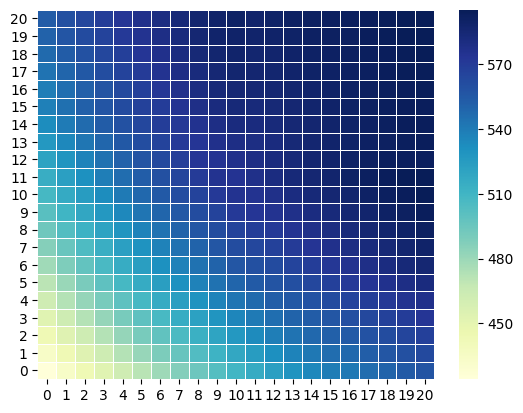

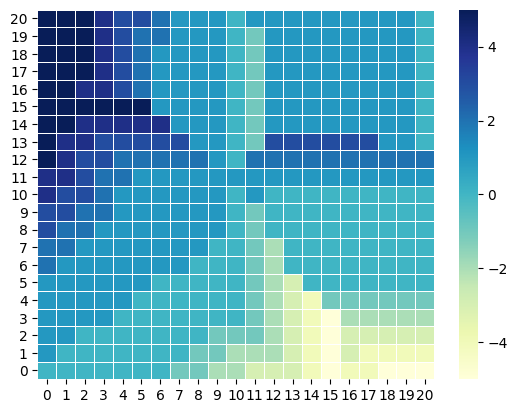

0.054351854527794785
0.029752586396000424
0.024359821261725756
0.019954981657292592
0.016351527617814554
0.013396957785914765
0.010973020080939477
0.008985450206978385
0.007356772277660184
0.006022793419617756
0.004930473369483934


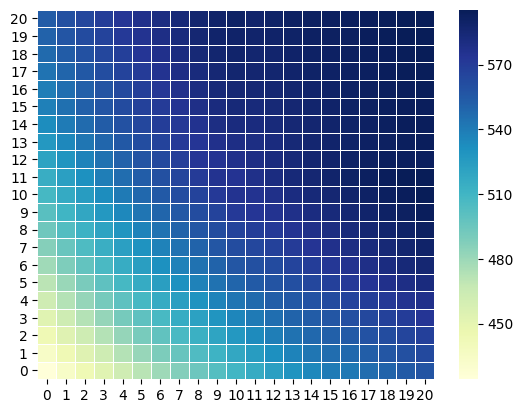

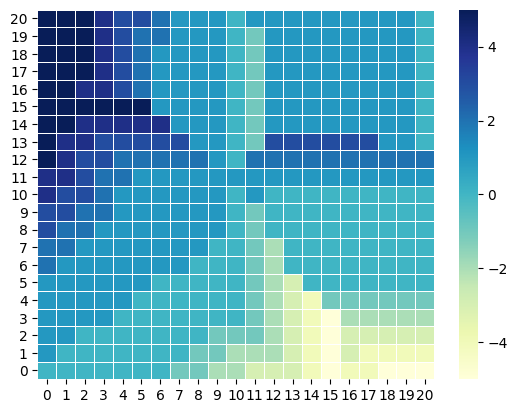

In [15]:
while(1):
    policy_evaluation()
    rho = policy_improvement()
    save_value()
    save_policy()
    if rho == True:
        break